# Feature Engineering

First, we will load the data into our DataFrame. Sort by date and denote which Season each match corresponds to. 

In [397]:
data_dir = "finalData.csv"
df = pd.read_csv(data_dir)

In [398]:
# renaming the columns
df.columns = ['Date', 'Home Team', 'Away Team', 'Full Time Home Goals', 'Full Time Away Goals', 'Full Time Result',       
'Half Time Home Goals', 'Half Time Away Goals', 'Half Time Result', 'Referee', 'Home Shots', 'Away Shots', 'Home Shots on Target',   
'Away Shots on Target', 'Home Corners', 'Away Corners', 'Home Fouls', 'Away Fouls', 'Home Yellow Cards', 'Away Yellow Cards',     
'Home Red Cards', 'Away Red Cards', 'Home Possession', 'Away Possession', 'Home Passes Completed', 'Home Passes PCT',
'Home Progressive Passes', 'Home Progressive Passing Distance', 'Home xG', 'Home Take Ons Won', 'Home Take Ons', 
'Home Interceptions', 'Home Blocks', 'Home Touches', 'Home Touches Def 3rd', 'Home Touches Mid 3rd', 'Home Touches Att 3rd',
'Home Carries', 'Home Carries Progressive Distance', 'Home Tackles', 'Home Tackles Won', 'Away Passes Completed',
'Away Passes PCT', 'Away Progressive Passes', 'Away Progressive Passing Distance', 'Away xG',
'Away Take Ons Won', 'Away Take Ons', 'Away Interceptions', 'Away Blocks', 'Away Touches', 'Away Touches Def 3rd',
'Away Touches Mid 3rd', 'Away Touches Att 3rd', 'Away Carries', 'Away Carries Progressive Distance', 'Away Tackles',
'Away Tackles Won']

In [399]:
# ensure sorted by date
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df = df.sort_values(by='Date')

# each season starts at 08 and ends at 05 of next year - 2000-2001 season will be the 2000 season
def get_season(date):
    if date.month >= 8:  
        return (date.year)
    else:  
        return (date.year - 1)

df['Season'] = df['Date'].apply(get_season)
df['Match Outcome'] = df['Full Time Result'].map({'H': 1, 'D': 0, 'A': -1})

Here, we begin engineering new features. The following function enables us to find the previous matches a team played (within this or the previous season). Using this key function, we created several features:

Average Goal Conversion Rate Difference, Average Attacking Intensity Difference, Average Disciplinary Pressure Difference, Recent Performances, Average Goals Scored Difference, Average Goals Conceded Difference, ...

Note: All averages use the previous RECENCY_NUM matches. If the number of previous matches in this season is too few, it will draw from the previous season as well. 

Note 2: After feature engineering, we will have to remove 101 matches that do not have RECENCY_NUM=5 matches prior. Unfortunately, this will reduce our dataset by 3.66%.

In [400]:
RECENCY_NUM = 5

In [401]:
# Team Points = total points in the game. win:3, draw:1, loss:0... DROPPED AFTERWARDS
# Total Points = cumulative sum of the team points, per team, per season
# Point Difference = difference between total points of the teams, per match
def calculate_season_points(df):
    df['Home Team Points'] = 0
    df['Away Team Points'] = 0

    for idx, row in df.iterrows():
        if row['Match Outcome'] == 1:  
            df.at[idx, 'Home Team Points'] = 3
            df.at[idx, 'Away Team Points'] = 0
        elif row['Match Outcome'] == 0: 
            df.at[idx, 'Home Team Points'] = 1
            df.at[idx, 'Away Team Points'] = 1
        elif row['Match Outcome'] == -1:  
            df.at[idx, 'Home Team Points'] = 0
            df.at[idx, 'Away Team Points'] = 3

    df['Home Total Seasonal Points'] = (df.groupby(['Home Team', 'Season'])['Home Team Points'].cumsum())
    df['Away Total Seasonal Points'] = (df.groupby(['Away Team', 'Season'])['Away Team Points'].cumsum())
    # df['Seasonal Point Difference'] = df['Home Total Seasonal Points'] - df['Away Total Seasonal Points']
    # df.drop(columns=['Home Team Points', 'Away Team Points'], inplace=True)

    return df
df = calculate_season_points(df)

In [402]:
def standardisation(df, terms=['Difference Average Goals Scored Last X Games', 'Difference Average Goals Conceded Last X Games', 'Point Difference', 'xG Difference']):
    scaler = StandardScaler()
    df[terms] = scaler.fit_transform(df[terms])
    return df

# normalises a specific set of columns
def normalisation(df, terms=['Difference Average Goals Scored Last X Games', 'Difference Average Goals Conceded Last X Games', 'Point Difference', 'xG Difference']):
    scaler = MinMaxScaler()
    df[terms] = scaler.fit_transform(df[terms])
    return df

# label encoding - use for boosting models
def label_encoding(df, col=['Home Team', 'Away Team'], dataframe=True):
    label_encoder = LabelEncoder()
    if dataframe:
        for c in col:
            df[c] = label_encoder.fit_transform(df[c])
    else:
        df = label_encoder.fit_transform(df)
    return df

Explained Variance Ratio:  [3.16576232e-01 8.45400333e-02 5.77480471e-02 4.98413595e-02
 3.97925540e-02 3.75659122e-02 3.41837323e-02 3.31313049e-02
 2.44209614e-02 2.42266364e-02 2.10247585e-02 1.90175701e-02
 1.81513320e-02 1.75881751e-02 1.65469751e-02 1.53220145e-02
 1.47904115e-02 1.39839348e-02 1.30258432e-02 1.25829526e-02
 1.18487923e-02 1.10295738e-02 1.02416566e-02 9.20479283e-03
 8.43066550e-03 7.85997645e-03 7.05260791e-03 6.22120658e-03
 5.48273633e-03 4.98185979e-03 4.62467530e-03 4.33793785e-03
 4.22584095e-03 4.05631205e-03 3.62936796e-03 3.54816995e-03
 3.00574141e-03 2.89590597e-03 2.75576708e-03 2.51615232e-03
 2.50223162e-03 2.20056031e-03 2.13312656e-03 1.82915504e-03
 1.59959876e-03 1.57101208e-03 1.52742630e-03 1.23717945e-03
 1.17426109e-03 1.06742370e-03 7.73061379e-04 2.30962891e-04
 1.20645223e-04 1.70988808e-05 2.93059148e-06 2.73610511e-06
 1.10141878e-07 8.65382054e-17]
Number of components to retain 95% variance: 31


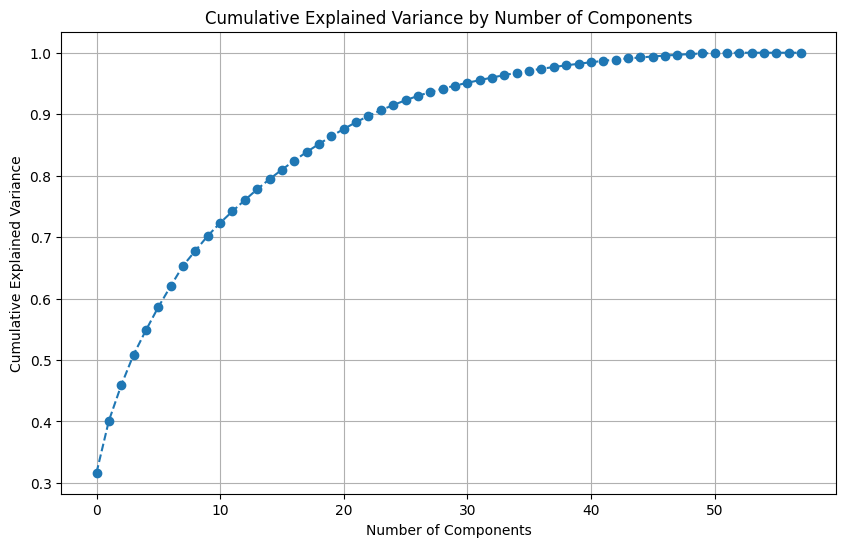

In [403]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def pca(df):
    # drop the irrelevant terms
    featuresToDrop = ['Date', 'Home Team', 'Away Team', 'Full Time Result', 'Half Time Result', 'Referee']
    assert set(featuresToDrop).issubset(df.columns), "Some columns in featuresToDrop are missing in df"
    df2 = df.drop(featuresToDrop, axis=1)
    
    df2 = standardisation(df2, terms=list(df2.columns))
    
    pca = PCA()
    pca_components = pca.fit_transform(df2)
    
    # find the explained variance ratio
    explained_variance = pca.explained_variance_ratio_
    print("Explained Variance Ratio: ", explained_variance)

    # select number of components based on explained variance (e.g., 95% variance)
    cumulative_variance = explained_variance.cumsum()
    n_components = next(i for i, v in enumerate(cumulative_variance) if v >= 0.95) + 1
    print(f"Number of components to retain 95% variance: {n_components}")

    # visualize explained variance
    plt.figure(figsize=(10, 6))
    plt.plot(cumulative_variance, marker='o', linestyle='--')
    plt.title('Cumulative Explained Variance by Number of Components')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.grid()
    plt.show()
    
    return n_components
    
number_of_components = pca(df)

Next, we reduced the feature data set to 5 sections of inputs: Home Advantage, Attacking Strength, Midfield Strength, Defensive Strength, and extras. 

Discarded features include: 

'Half Time Home Goals', 'Half Time Away Goals', 'Half Time Result', 'Referee', 'Home Shots', 'Away Shots', 'Home Fouls', 'Away Fouls', 'Home Yellow Cards', 'Away Yellow Cards', 'Home Red Cards', 'Away Red Cards', 'Home Possession', 'Away Possession', 'Home Progressive Passing Distance', 'Home xG', 'Home Take Ons', 'Home Touches', 'Home Touches Def 3rd', 'Home Carries Progressive Distance', 'Away Progressive Passing Distance', 'Away xG', 'Away Take Ons', 'Away Touches', 'Away Touches Def 3rd', 'Away Carries Progressive Distance', 'Season', 'Home Team Points', 'Away Team Points', 'Home Total Seasonal Points', 'Away Total Seasonal Points'

In [404]:
features = [
    # Home Advantage
    "Home Team",
    "Away Team",
    "Match Outcome",
    "Full Time Home Goals",
    "Full Time Away Goals",
    
    # Attacking Strength
    "Home Shots on Target", "Away Shots on Target",
    "Home Progressive Passes", "Away Progressive Passes",
    "Home Touches Att 3rd", "Away Touches Att 3rd",
    "Home Take Ons Won", "Away Take Ons Won",
    "Home Corners", "Away Corners",
    
    # Midfield Strength
    "Home Touches Mid 3rd", "Away Touches Mid 3rd",
    "Home Passes Completed", "Away Passes Completed",
    "Home Passes PCT", "Away Passes PCT",
    "Home Carries", "Away Carries",
    
    # Defensive Strength
    "Home Tackles", "Away Tackles",
    "Home Tackles Won", "Away Tackles Won",
    "Home Blocks", "Away Blocks",
    "Home Interceptions", "Away Interceptions",
    
    # Extra
    "Full Time Result",
    'Date'
]

new_df = df[features].copy()
new_df.dropna(inplace=True)

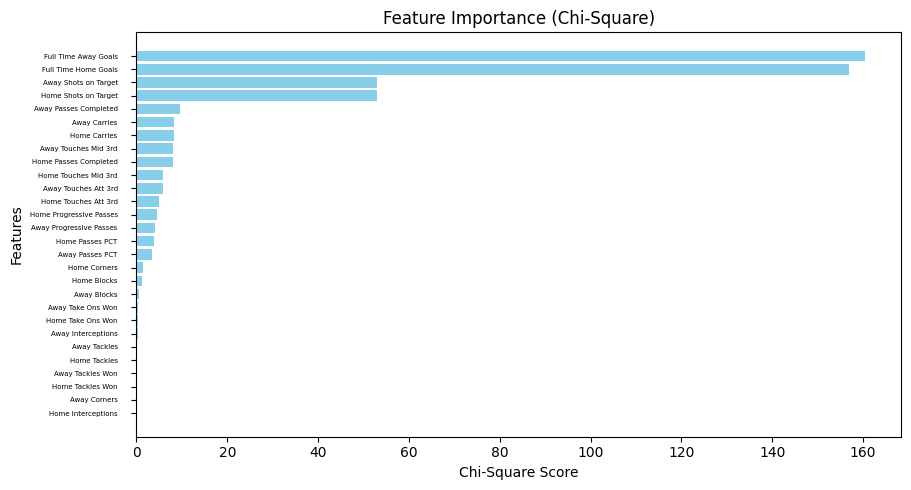

In [408]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

def chi_square(df):
    # organise dataset into X (training examples) and y (targets)
    featuresToDrop = ['Date', 'Home Team', 'Full Time Result', 'Away Team', 'Match Outcome']
    assert set(featuresToDrop).issubset(df.columns), "Some columns in featuresToDrop are missing in df"
    data = df.drop(featuresToDrop, axis=1)
    df['Match Outcome'] = df['Full Time Result'].map({'H': 1, 'D': 0, 'A': -1})
    target = df['Match Outcome']
    
    # chi2 scoring function requires non-negative input: normalisation
    data = normalisation(data, terms=list(data.columns))
    
    # collect the feature names
    feature_names = list(data.columns)
    
    # perform chi square selection    
    chi_select = SelectKBest(chi2, k=min(number_of_components, len(data.columns)))
    new_data = chi_select.fit_transform(data, target)
    
    # collect features
    selected_features = []
    for i, b in enumerate(chi_select.get_support()):
        if b:
            selected_features.append(feature_names[i])
    
    # get the chi-square scores for all features
    chi_scores = chi_select.scores_

    # create a dataFrame for easy visualization
    chi2_df = pd.DataFrame({'Feature': feature_names, 'Chi-Square Score': chi_scores})
    chi2_df = chi2_df.sort_values(by='Chi-Square Score', ascending=False)

    # plot the scores
    plt.figure(figsize=(10, 5))
    colours = ['skyblue' if i < number_of_components else 'gray' for i in range(len(chi2_df))]
    plt.barh(chi2_df['Feature'], chi2_df['Chi-Square Score'], color=colours)
    plt.xlabel('Chi-Square Score')
    plt.ylabel('Features')
    plt.title('Feature Importance (Chi-Square)')
    plt.gca().invert_yaxis()  # Invert y-axis to show the highest scores at the top
    plt.tight_layout()
    plt.tick_params(axis="y", pad=10, labelsize=5)
    plt.show()
    
    return chi2_df
    
chi2_df = chi_square(new_df)   

Now we will take the feature importance scores from the Chi-Square distribution and adjust the weights to approach a gradual steady decline. This will allow the less important features to contribute to our feature engineering later while preserving a hierarchical ranking. 

Note: the number 1/3 was chosen arbitrarily but it was observed to be a standard heuristic among Machine Learning papers.

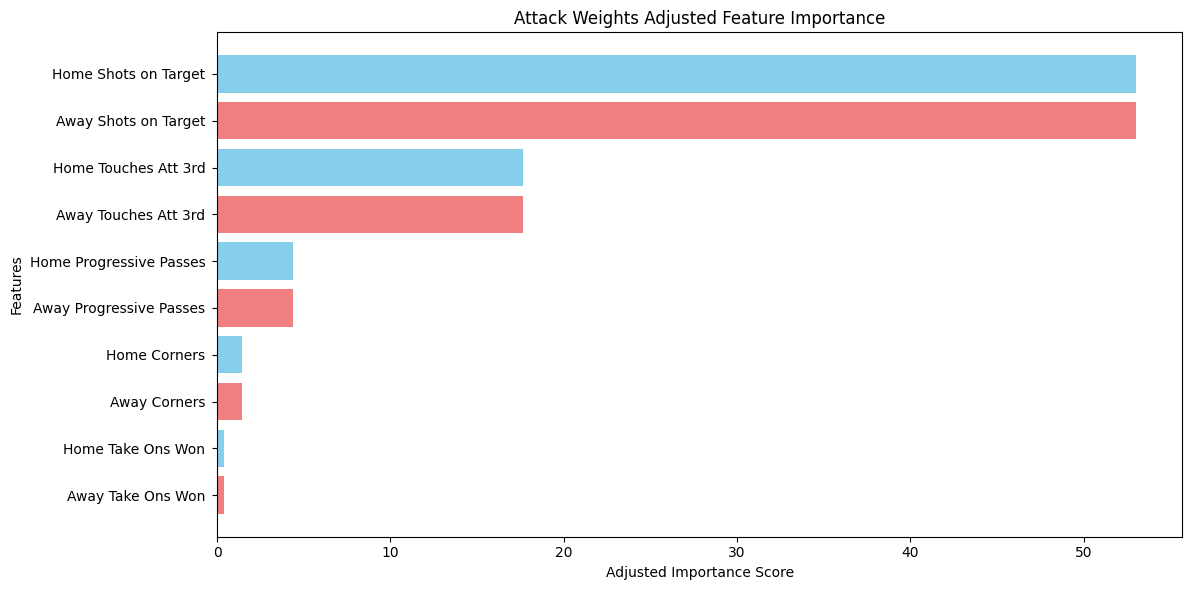

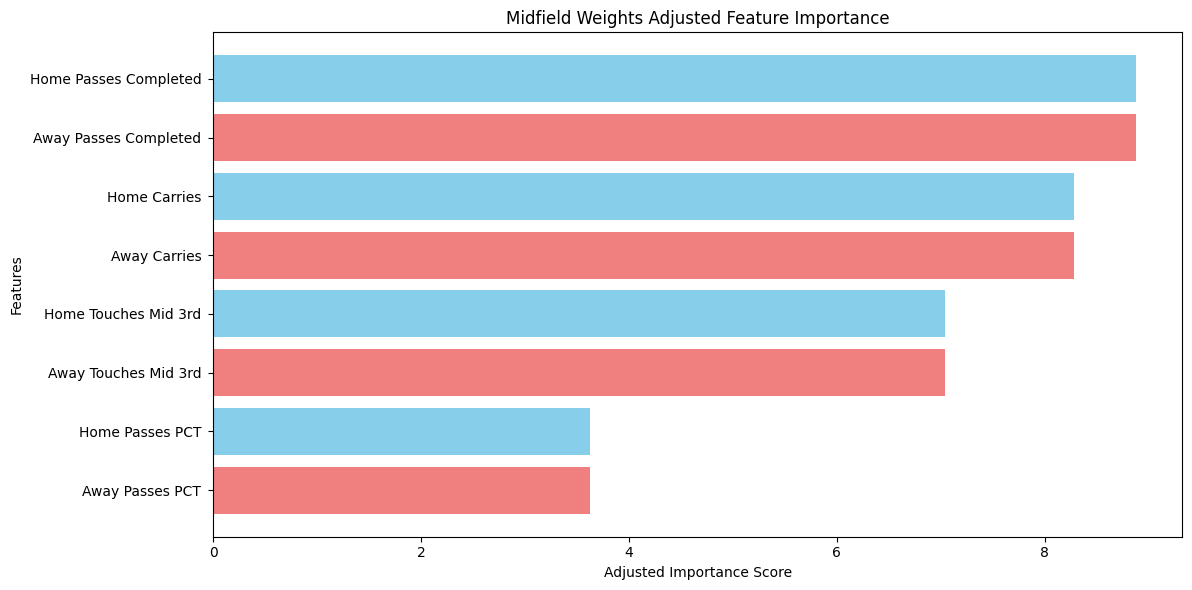

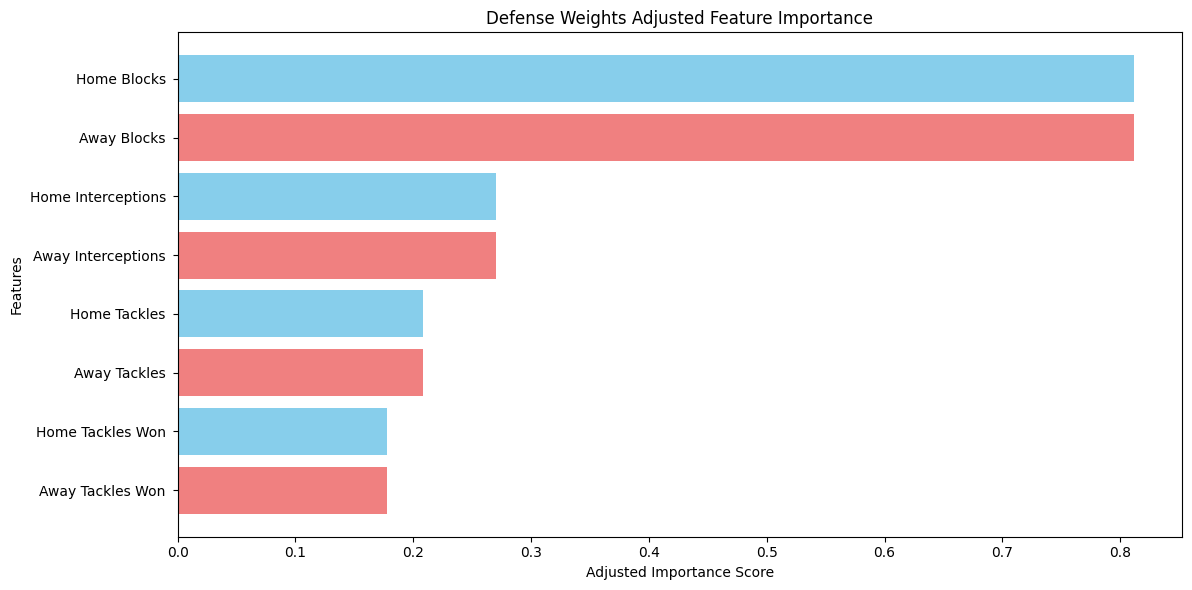

In [409]:
def adjust_feature_weights(features, chi2_df):
    # Aggregate Home and Away importance scores
    aggregated_scores = {}
    for feature_pair in features:
        home_feature, away_feature = feature_pair
        home_score = chi2_df.loc[chi2_df['Feature'] == home_feature, 'Chi-Square Score'].values[0]
        away_score = chi2_df.loc[chi2_df['Feature'] == away_feature, 'Chi-Square Score'].values[0]
        aggregated_scores[feature_pair] = home_score + away_score

    # Sort features by aggregated importance
    sorted_features = sorted(aggregated_scores.items(), key=lambda x: x[1], reverse=True)
    
    # Adjust scores using the /3 rule
    adjusted_scores = {}
    adjusted_scores[sorted_features[0][0]] = sorted_features[0][1]  # Most important feature remains unchanged
    
    for i in range(1, len(sorted_features)):
        current_feature, current_score = sorted_features[i]
        previous_feature, previous_score = sorted_features[i - 1]
        
        if current_score < previous_score / 3:
            current_score = previous_score / 3
        adjusted_scores[current_feature] = current_score

    # Assign adjusted scores equally to Home and Away features
    final_weights = {}
    for feature_pair, score in adjusted_scores.items():
        home_feature, away_feature = feature_pair
        final_weights[home_feature] = score / 2
        final_weights[away_feature] = score / 2
    
    return final_weights

def plot_adjusted_features(weights, title):
    # prepare data for plotting
    features = list(weights.keys())
    importance = list(weights.values())

    # create the plot
    plt.figure(figsize=(12, 6))
    colours = ['skyblue' if 'Home' in feature else 'lightcoral' for feature in features]
    plt.barh(features, importance, color=colours)

    # customize the plot
    plt.xlabel('Adjusted Importance Score')
    plt.ylabel('Features')
    plt.title(title)
    plt.gca().invert_yaxis()  # highest scores at the top
    plt.tight_layout()
    plt.tick_params(axis="y", pad=5, labelsize=10)  # adjust y-axis label size for better visibility
    plt.show()


def create_strength_features_separate(df, chi2_df):
    # Define feature pairs for each group
    attack_features = [
        ("Home Shots on Target", "Away Shots on Target"),
        ("Home Progressive Passes", "Away Progressive Passes"),
        ("Home Touches Att 3rd", "Away Touches Att 3rd"),
        ("Home Take Ons Won", "Away Take Ons Won"),
        ("Home Corners", "Away Corners")
    ]
    midfield_features = [
        ("Home Touches Mid 3rd", "Away Touches Mid 3rd"),
        ("Home Passes Completed", "Away Passes Completed"),
        ("Home Passes PCT", "Away Passes PCT"),
        ("Home Carries", "Away Carries")
    ]
    defense_features = [
        ("Home Tackles", "Away Tackles"),
        ("Home Tackles Won", "Away Tackles Won"),
        ("Home Blocks", "Away Blocks"),
        ("Home Interceptions", "Away Interceptions")
    ]
    
    # Adjust weights for each group
    attack_weights = adjust_feature_weights(attack_features, chi2_df)
    midfield_weights = adjust_feature_weights(midfield_features, chi2_df)
    defense_weights = adjust_feature_weights(defense_features, chi2_df)
    
    plot_adjusted_features(attack_weights, "Attack Weights Adjusted Feature Importance")
    plot_adjusted_features(midfield_weights, "Midfield Weights Adjusted Feature Importance")
    plot_adjusted_features(defense_weights, "Defense Weights Adjusted Feature Importance")
    
    # Calculate strength scores for Home and Away
    def calculate_strength(feature_pairs, weights, team_type):
        strength_score = 0
        for home_feature, away_feature in feature_pairs:
            feature = home_feature if team_type == "Home" else away_feature
            strength_score += df[feature] * weights[feature]
        return strength_score

    # Compute Home and Away strengths for Attack, Midfield, and Defense
    df['Home Attack Strength'] = calculate_strength(attack_features, attack_weights, "Home")
    df['Away Attack Strength'] = calculate_strength(attack_features, attack_weights, "Away")
    df['Home Midfield Strength'] = calculate_strength(midfield_features, midfield_weights, "Home")
    df['Away Midfield Strength'] = calculate_strength(midfield_features, midfield_weights, "Away")
    df['Home Defense Strength'] = calculate_strength(defense_features, defense_weights, "Home")
    df['Away Defense Strength'] = calculate_strength(defense_features, defense_weights, "Away")
    
    return df



strength_df = create_strength_features_separate(new_df, chi2_df)

In [411]:
def avg_stats_last_x_games(df):
    
    def calculate_running_avg(stats_list, x):
        if len(stats_list) < x:
            return None
        return sum(stats_list[-x:]) / x

    metrics = ['Goals Scored', 'Goals Conceded', 'Attack Strength', 'Midfield Strength', 'Defense Strength', 'Recent Performance']# , 'xG', 'Disciplinary Pressure']
    for metric in metrics:
        for x in range(1, RECENCY_NUM + 1):
            df[f'Avg {metric} Home Last {x} Games'] = None
            df[f'Avg {metric} Away Last {x} Games'] = None
    running_stats = {}

    for idx, row in df.iterrows():
        for team_type in ['Home Team', 'Away Team']:
            team = row[team_type]
            stat_type = team_type.split()[0]  # Home or Away

            if team not in running_stats:
                running_stats[team] = {
                    'Goals Scored': [],
                    'Goals Conceded': [],
                    'Attack Strength': [],
                    'Midfield Strength': [],
                    'Defense Strength': [],
                    #'Disciplinary Pressure': [],
                    'Recent Performance': []
                }

            team_stats = running_stats[team]

            for x in range(1, RECENCY_NUM + 1):
                for metric in metrics:
                    avg_stat = calculate_running_avg(team_stats[metric], x)
                    df.at[idx, f'Avg {metric} {stat_type} Last {x} Games'] = avg_stat
            team_stats['Goals Scored'].append(row['Full Time Home Goals'] if stat_type == 'Home' else row['Full Time Away Goals'])
            team_stats['Goals Conceded'].append(row['Full Time Away Goals'] if stat_type == 'Home' else row['Full Time Home Goals'])
            team_stats['Attack Strength'].append(row['Home Attack Strength'] if stat_type == 'Home' else row['Away Attack Strength'])
            team_stats['Midfield Strength'].append(row['Home Midfield Strength'] if stat_type == 'Home' else row['Away Midfield Strength'])
            team_stats['Defense Strength'].append(row['Home Defense Strength'] if stat_type == 'Home' else row['Away Defense Strength'])
            #team_stats['xG'].append(row['xG Home'] if stat_type == 'Home' else row['xG Away'])
            #team_stats['Disciplinary Pressure'].append(row['Home Disciplinary Pressure'] if stat_type == 'Home' else row['Away Disciplinary Pressure'])
            team_stats['Recent Performance'].append(1 if (row['Full Time Result'] == 'H' and stat_type == 'Home') or (row['Full Time Result'] == 'A' and stat_type == 'Away') else 0.5 if row['Full Time Result'] == 'D' else 0)
    return df

df = avg_stats_last_x_games(strength_df)
df.dropna(inplace=True)    # removes the matches without enough X previous data

In [412]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split

def chronological_split(df, train_ratio=0.8, chronological=False):
    df = df.sort_values(by='Date')
    df.drop(columns=['Date'], inplace=True)
    df.dropna(inplace=True)
    if chronological:
        train_size = int(len(df) * train_ratio)
        train_df = df[:train_size]
        test_df = df[train_size:]
    else:
        train_df, test_df = train_test_split(df, train_size=train_ratio, random_state=31, shuffle=True)
    return train_df, test_df

def encode_teams(df, encoding="one-hot"):
    if encoding == "one-hot":
        encoder = OneHotEncoder()
        encoded_teams = encoder.fit_transform(df[['Home Team']]).toarray()
        encoded_team_columns = encoder.get_feature_names_out(['Home Team'])
        
        encoded_df = pd.DataFrame(encoded_teams, columns=encoded_team_columns, index=df.index)
        df = pd.concat([df, encoded_df], axis=1)
        return df.drop(['Home Team'], axis=1)
    else:
        teams = df['Home Team'].unique()        
        encoder = LabelEncoder()
        encoder.fit(teams)
        
        df['Home Team'] = encoder.transform(df['Home Team'])
        
        return df
    
def standardize_features(df, features, scale_type='minmax'):
    if scale_type == 'minmax':
        scaler = MinMaxScaler()
    else: 
        scaler = StandardScaler()
    
    df[features] = scaler.fit_transform(df[features])
    return df

In [414]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import root_mean_squared_error, accuracy_score, precision_recall_fscore_support
from sklearn.neighbors import KNeighborsClassifier
import joblib
import numpy as np
import matplotlib.pyplot as plt

class RecencyModelTraining:
    def __init__(self):
        pass
    
    # Logistic Regression tests
    def train_with_iterations(self, X_train, y_train, X_test, y_test, iterations):
        metrics = {
            'train_error': [],
            'test_error': [],
            'train_accuracy': [],
            'test_accuracy': [],
            'train_rmse': [],
            'test_rmse': [],
            'train_precision': [],
            'test_precision': [],
            'train_recall': [],
            'test_recall': [],
            'train_f1': [],
            'test_f1': []
        }

        for max_iter in iterations:
            self.model = LogisticRegression(
                multi_class='multinomial',
                solver='lbfgs',
                max_iter=max_iter,
                # class_weight='balanced',
                # penalty='elasticnet',
                # l1_ratio=0.0,
                random_state=31
            )
            self.model.fit(X_train, y_train)

            # Predictions
            train_predictions = self.model.predict(X_train)
            test_predictions = self.model.predict(X_test)

            # Accuracy
            train_accuracy = accuracy_score(y_train, train_predictions)
            test_accuracy = accuracy_score(y_test, test_predictions)

            # Errors
            metrics['train_error'].append(1 - train_accuracy)
            metrics['test_error'].append(1 - test_accuracy)
            metrics['train_accuracy'].append(train_accuracy)
            metrics['test_accuracy'].append(test_accuracy)

            # RMSE
            metrics['train_rmse'].append(np.sqrt(np.mean((y_train - train_predictions) ** 2)))
            metrics['test_rmse'].append(np.sqrt(np.mean((y_test - test_predictions) ** 2)))

            # Precision, Recall, F1
            train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(
                y_train, train_predictions, average='weighted'
            )
            test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(
                y_test, test_predictions, average='weighted'
            )

            metrics['train_precision'].append(train_precision)
            metrics['test_precision'].append(test_precision)
            metrics['train_recall'].append(train_recall)
            metrics['test_recall'].append(test_recall)
            metrics['train_f1'].append(train_f1)
            metrics['test_f1'].append(test_f1)

        return metrics

    # K Nearest Neighbours tests
    def train_and_evaluate_knn(self, X_train, y_train, X_test, y_test, neighbors_range):
        metrics = {
            'train_accuracy': [],
            'test_accuracy': [],
            'train_rmse': [],
            'test_rmse': [],
            'train_precision': [],
            'test_precision': [],
            'train_recall': [],
            'test_recall': [],
            'train_f1': [],
            'test_f1': []
        }

        for n_neighbors in neighbors_range:
            # Train KNN model
            knn = KNeighborsClassifier(n_neighbors=n_neighbors)
            knn.fit(X_train, y_train)

            # Predictions
            train_predictions = knn.predict(X_train)
            test_predictions = knn.predict(X_test)

            # Accuracy
            train_accuracy = accuracy_score(y_train, train_predictions)
            test_accuracy = accuracy_score(y_test, test_predictions)
            metrics['train_accuracy'].append(train_accuracy)
            metrics['test_accuracy'].append(test_accuracy)

            metrics['train_rmse'].append(np.sqrt(np.mean((y_train - train_predictions) ** 2)))
            metrics['test_rmse'].append(np.sqrt(np.mean((y_test - test_predictions) ** 2)))

            # Precision, Recall, F1
            train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(
                y_train, train_predictions, average='weighted'
            )
            test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(
                y_test, test_predictions, average='weighted'
            )

            metrics['train_precision'].append(train_precision)
            metrics['test_precision'].append(test_precision)
            metrics['train_recall'].append(train_recall)
            metrics['test_recall'].append(test_recall)
            metrics['train_f1'].append(train_f1)
            metrics['test_f1'].append(test_f1)

        return metrics
    
    def plot_knn_metrics(self, metrics, neighbors_range):
        metric_keys = list(metrics.keys())
        n_metrics = len(metric_keys)

        plt.figure(figsize=(15, 10))
        for i, key in enumerate(metric_keys, 1):

            plt.subplot((n_metrics + 1) // 2, 2, i)
            plt.plot(neighbors_range, metrics[key], label=key, marker='o')

            # Add formatted labels for each point
            for x, y in zip(neighbors_range, metrics[key]):
                plt.text(
                    x, y, f'{y:.2f}', fontsize=8, ha='center', va='bottom'
                )

            plt.xlabel('Number of Neighbors')
            plt.ylabel(f'{key}')
            plt.title(f'{key} over Number of Neighbors')
            plt.grid()

        plt.tight_layout()
        plt.show()

    def plot_logistic_metrics(self, metrics, iterations):
        metric_keys = list(metrics.keys())
        n_metrics = len(metric_keys)

        plt.figure(figsize=(15, 10))
        for i, key in enumerate(metric_keys, 1):
            plt.subplot((n_metrics + 1) // 2, 2, i)  
            plt.plot(iterations, metrics[key], label=key, marker='o')

            for x, y in zip(iterations, metrics[key]):
                plt.text(
                    x, y, f'{y:.3f}', fontsize=7, ha='center', va='bottom'
                )

            plt.xlabel('Iterations')
            plt.ylabel(f'{key}')
            plt.title(f'{key} over Iterations')
            plt.grid()

        plt.tight_layout()
        plt.show()

    def save_model(self, filename):
        joblib.dump(self.model, filename)

    def load_model(self, filename):
        self.model = joblib.load(filename)

In [415]:
features = [
    'Avg Goals Scored Home Last 1 Games',
       'Avg Goals Scored Away Last 1 Games',
       'Avg Goals Scored Home Last 2 Games',
       'Avg Goals Scored Away Last 2 Games',
       'Avg Goals Scored Home Last 3 Games',
       'Avg Goals Scored Away Last 3 Games',
       'Avg Goals Scored Home Last 4 Games',
       'Avg Goals Scored Away Last 4 Games',
       'Avg Goals Scored Home Last 5 Games',
       'Avg Goals Scored Away Last 5 Games',
       'Avg Goals Conceded Home Last 1 Games',
       'Avg Goals Conceded Away Last 1 Games',
       'Avg Goals Conceded Home Last 2 Games',
       'Avg Goals Conceded Away Last 2 Games',
       'Avg Goals Conceded Home Last 3 Games',
       'Avg Goals Conceded Away Last 3 Games',
       'Avg Goals Conceded Home Last 4 Games',
       'Avg Goals Conceded Away Last 4 Games',
       'Avg Goals Conceded Home Last 5 Games',
       'Avg Goals Conceded Away Last 5 Games',
       'Avg Attack Strength Home Last 1 Games',
       'Avg Attack Strength Away Last 1 Games',
       'Avg Attack Strength Home Last 2 Games',
       'Avg Attack Strength Away Last 2 Games',
       'Avg Attack Strength Home Last 3 Games',
       'Avg Attack Strength Away Last 3 Games',
       'Avg Attack Strength Home Last 4 Games',
       'Avg Attack Strength Away Last 4 Games',
       'Avg Attack Strength Home Last 5 Games',
       'Avg Attack Strength Away Last 5 Games',
       'Avg Midfield Strength Home Last 1 Games',
       'Avg Midfield Strength Away Last 1 Games',
       'Avg Midfield Strength Home Last 2 Games',
       'Avg Midfield Strength Away Last 2 Games',
       'Avg Midfield Strength Home Last 3 Games',
       'Avg Midfield Strength Away Last 3 Games',
       'Avg Midfield Strength Home Last 4 Games',
       'Avg Midfield Strength Away Last 4 Games',
       'Avg Midfield Strength Home Last 5 Games',
       'Avg Midfield Strength Away Last 5 Games',
       'Avg Defense Strength Home Last 1 Games',
       'Avg Defense Strength Away Last 1 Games',
       'Avg Defense Strength Home Last 2 Games',
       'Avg Defense Strength Away Last 2 Games',
       'Avg Defense Strength Home Last 3 Games',
       'Avg Defense Strength Away Last 3 Games',
       'Avg Defense Strength Home Last 4 Games',
       'Avg Defense Strength Away Last 4 Games',
       'Avg Defense Strength Home Last 5 Games',
       'Avg Defense Strength Away Last 5 Games',
       'Avg Recent Performance Home Last 1 Games',
       'Avg Recent Performance Away Last 1 Games',
       'Avg Recent Performance Home Last 2 Games',
       'Avg Recent Performance Away Last 2 Games',
       'Avg Recent Performance Home Last 3 Games',
       'Avg Recent Performance Away Last 3 Games',
       'Avg Recent Performance Home Last 4 Games',
       'Avg Recent Performance Away Last 4 Games',
       'Avg Recent Performance Home Last 5 Games',
       'Avg Recent Performance Away Last 5 Games',
       'Home Team',
       'Match Outcome',
       'Date'
]
df = df[features]

Preprocessing Data...
Starting Training...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: Und

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Library/Frameworks/Pytho

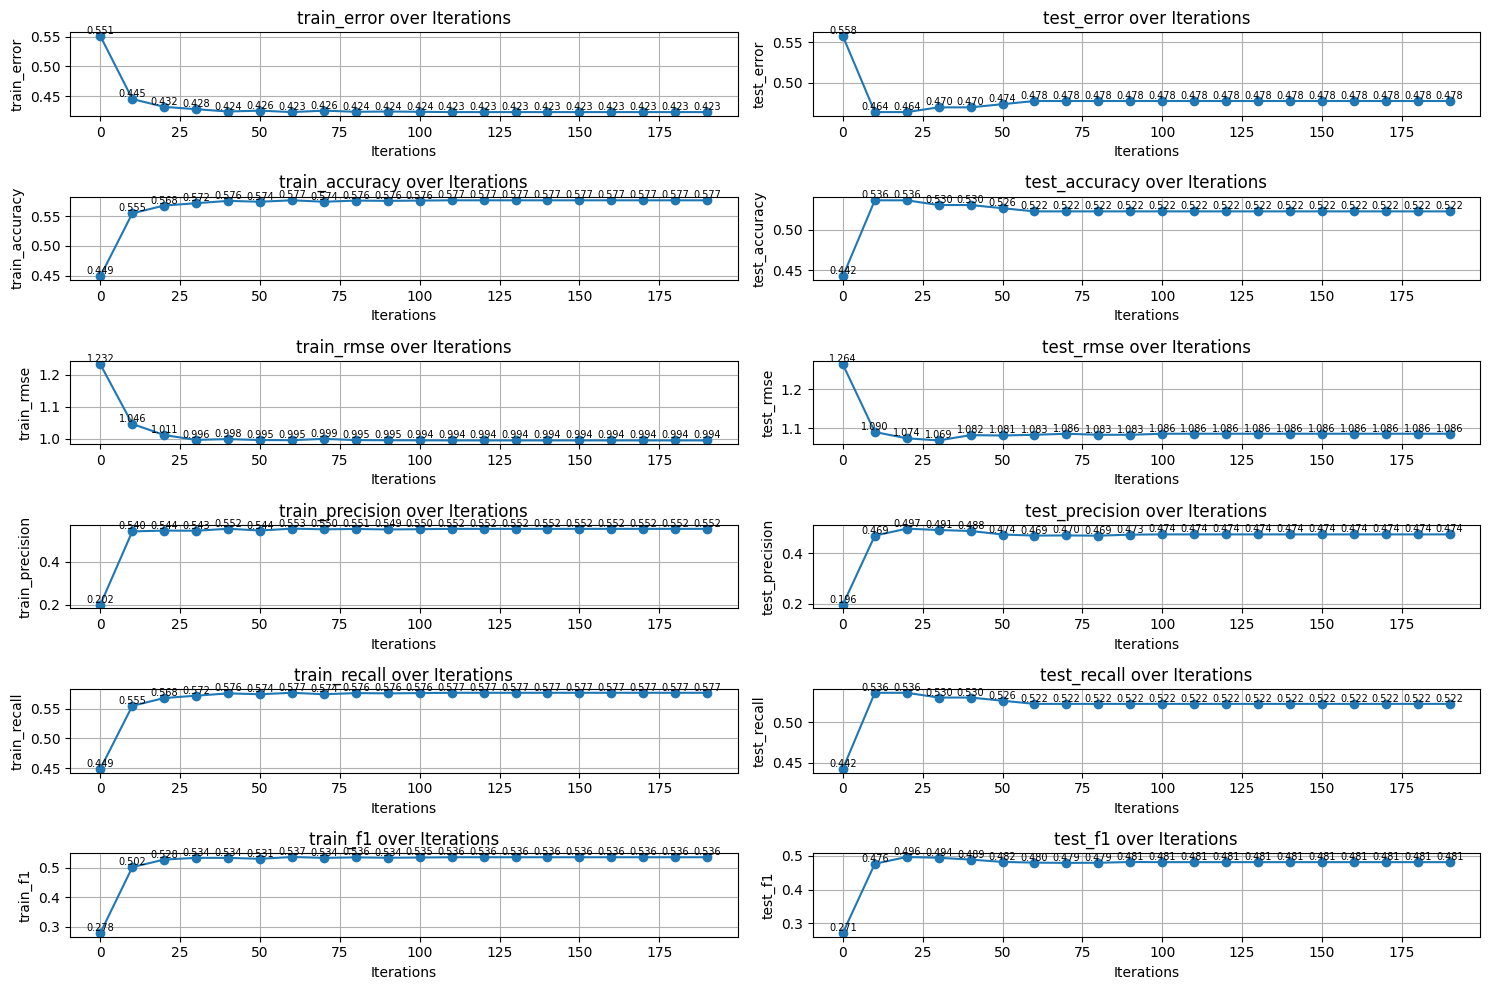

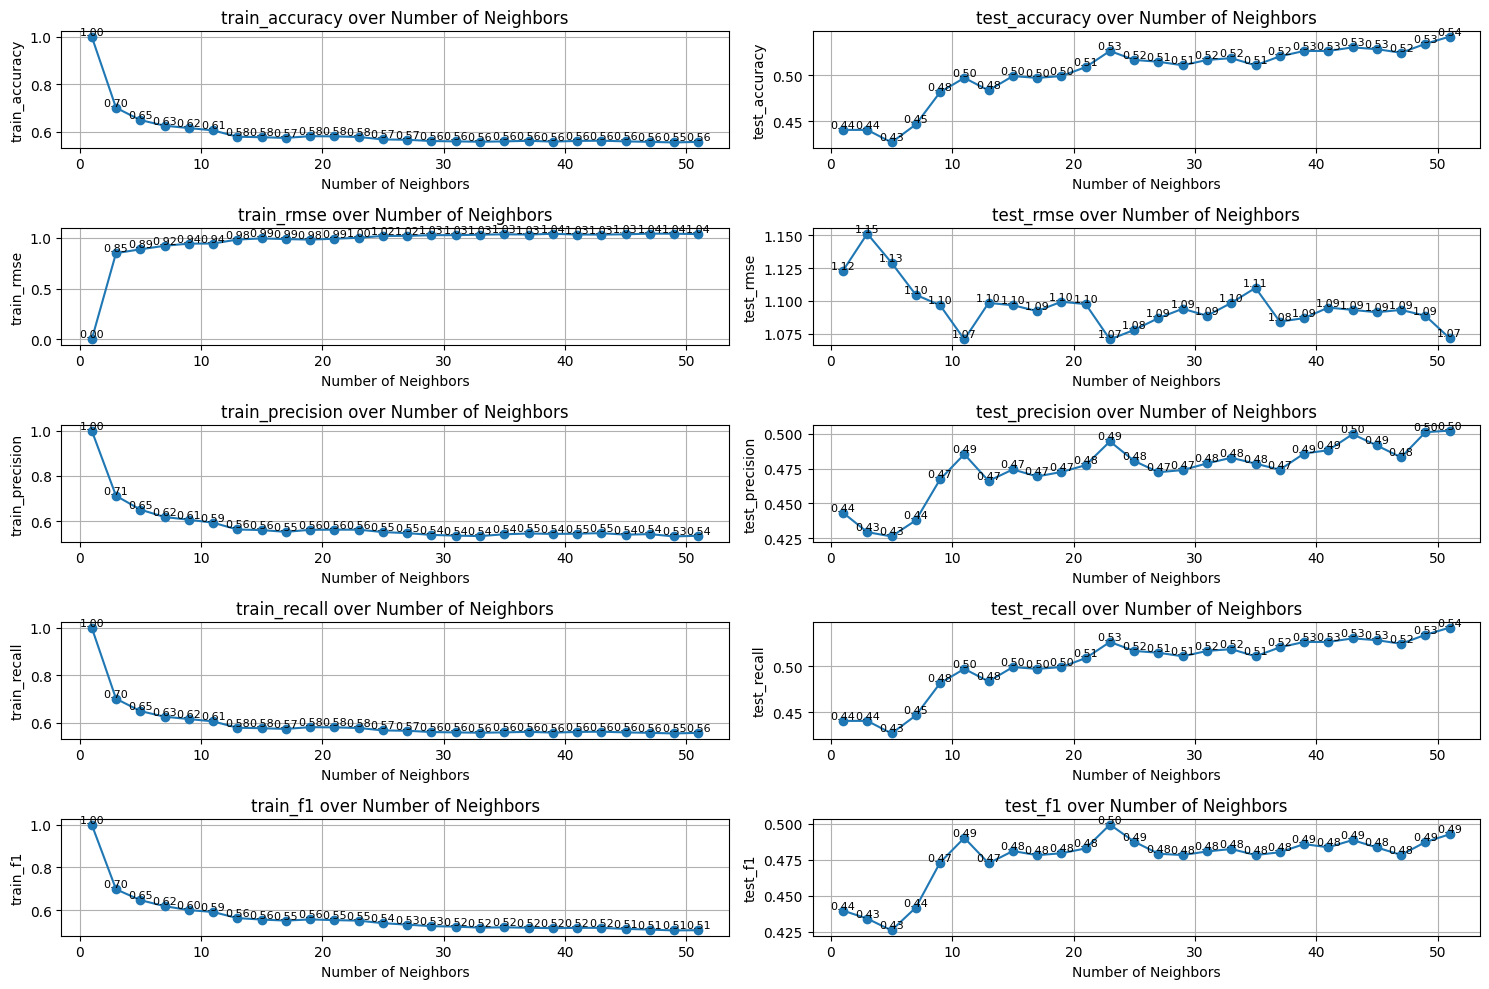

In [416]:
import pandas as pd
import numpy as np

print('Preprocessing Data...')
df = encode_teams(df)
numerical_features = [col for col in df.columns if 'Avg' in col]
df = standardize_features(df, numerical_features)

train_df, test_df = chronological_split(df)

X_train, y_train = train_df.drop('Match Outcome', axis=1), train_df['Match Outcome']
X_test, y_test = test_df.drop('Match Outcome', axis=1), test_df['Match Outcome']

# Model Training
print('Starting Training...')

trainer = RecencyModelTraining()

iterations = np.arange(0, 200, 10)
neighbors_range = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51]

metrics_logistic = trainer.train_with_iterations(X_train, y_train, X_test, y_test, iterations)
metrics_knn = trainer.train_and_evaluate_knn(X_train, y_train, X_test, y_test, neighbors_range)
trainer.plot_logistic_metrics(metrics_logistic, iterations)
trainer.plot_knn_metrics(metrics_knn, neighbors_range=neighbors_range)